코드 생성

In [536]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate

from mpl_toolkits.mplot3d import Axes3D
from collections import deque  
import random as rand

sats = [(1, 5), (2, 6), (3, 7), (4, 8), (0, 8), (1, 9), (0, 7), (1, 8), (2, 9), (1, 2),
            (2, 3), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (0, 3), (1, 4), (2, 5), (3, 6),
            (4, 7), (5, 8), (0, 2), (3, 5), (4, 6), (5, 7), (6, 8), (7, 9), (0, 5), (1, 6),
            (2, 7), (3, 8), (4, 9), (3, 9), (0, 6), (1, 7), (3, 9)]
g1tap = [2,9]
g2tap = [1,2,5,7,8,9]
# -5000, -4500, -4000, -3500, -3000, -2500, -2000, -1500, -1000, -500, 0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000
def getCode(satsNum):
    
    g1 = deque(1 for i in range(10))
    g2 = deque(1 for i in range(10))
     
    # result
    g = []
    
    # Generating 1023 chips(One C/A sequence)
    for i in range(1023):
        val = (g1[9] + g2[satsNum[0]] + g2[satsNum[1]]) % 2
        g.append(val)
        
        #shift g1
        g1[9] = sum(g1[i] for i in g1tap) % 2
        g1.rotate()
        
        #shift g2
        g2[9] = sum(g2[i] for i in g2tap) % 2
        g2.rotate()
    # 0 => -1
    for n,i in enumerate(g):
            if i==0:
                g[n]=-1
        
    return g

# 코드 미리 만들어두기(시간복잡도 줄이려고)
codes = []
for i in range(37):
    codes.append(getCode(sats[i]))

In [537]:
OV = 10
ms = 300 # message 한 bit 마다 20ms #원래는 2초 봐야해서 2000

# C/A code Frequency : 1.023MHz
# IF Frequency : 9.548MHz
# Sampling rate : 38.192MHz
# OV should be 4?
# 알아낸 곳: Kai Borre의 A Software-Defined GPS and Galileo Receiver에서의 p.55(pdf 상으로는 70페이지)
# 이것들 적용해야 하는데, 아직 할 줄 모른다...

Noise 생성

In [538]:
# 잡음의 전력 비 설정 (잡음은 전력 1, 신호전력은 1/6.31 이런 식으로 만들기)
# noise_power = 6.31 # For -8dB. If -22dB, set noise_power to 158.49

# 6.31 ~ 158.49 중 랜덤하게 생성
noise_power = rand.uniform(6.31, 158.49)

# 잡음의 길이 설정
num_samples = 1023 *20 * (ms//20) * OV

# 실수부와 허수부에 대한 잡음 생성
real_noise = np.random.normal(0, 1/ (np.sqrt(2) * np.sqrt(OV)), num_samples) 
imaginary_noise = np.random.normal(0, 1/ (np.sqrt(2) * np.sqrt(OV)), num_samples) 

# 복소수로 변환
complex_noise = (real_noise + 1j * imaginary_noise) 

# 신호가 쓸 거
sigma = np.sqrt(noise_power)
print("Current Noise Power:", noise_power)

Current Noise Power: 79.1151879879426


Data 생성

In [539]:
data = []
for i in range(ms//20):
    data.append(rand.choice([1,-1]))
    #data.append((1)**i)
RN = rand.randint(0,36)
t_code = codes[RN]
t_code = [chip/(sigma*np.sqrt(OV)) for chip in t_code for _ in range(OV)]
t_code_inv = [x*-1 for x in t_code]
seq = []

# data = [1,1,-1,-1,-1]

for d in data:
    if d == 1:
        seq.extend(t_code*20)
    else:
        seq.extend(t_code_inv*20)



Signal 생성

In [540]:
class trans_signal:
    def __init__(self, code_delay, doppler_freq, svNumber, code_freq, bits, OV):
        self.delay = code_delay
        self.doppler = doppler_freq
        self.svNumber = svNumber
        self.code_freq = code_freq
        
        self.seq = np.roll(seq, code_delay) # code_delay : delay된 sample 수
        self.t = np.arange(1023 * OV * 20 * bits)
        self.oversampled_signal = np.exp(1j * 2 * np.pi * (doppler_freq + code_freq) * self.t / (1.023e6 * OV))
    def signal(self):
        return self.seq * self.oversampled_signal + complex_noise       
    def shift(self, tvar):
        #self.t = self.t + tvar
        self.seq = np.roll(self.seq, -tvar)
        #self.oversampled_signal = np.exp(1j * 2 * np.pi * (self.doppler + self.code_freq) * self.t / (1.023e6 * OV))
        

Replica 신호 생성

In [541]:
class Replica:
    def __init__(self, code_delay, doppler_freq, code_freq, svNumber, signal_length, OV, t0): # t0 = 이전 carrier의 마지막 phase. 교수님이 그려 주신 그림에서 Φ_n 말하는 거임 
        ca_code = np.array(codes[svNumber])
        ca_code = [chip for chip in ca_code for _ in range(OV)]
        self.delayed_code = np.roll(ca_code, code_delay)
        
        t = np.arange(0, signal_length + 1)
        temp = np.exp(1j * 2 * np.pi * (doppler_freq + code_freq) * t / (1.023e6 * OV)) * t0 # 그거 여기에 곱해줌
        self.oversampled_signal = temp[:-1]
        
        self.last = temp[-1] # 다음 replica에서 사용할 Φ_(n+1) (누적)
    def delay(self, delay):
        self.delayed_code = np.roll(self.delayed_code, delay)
    def signal(self):
        return self.delayed_code * self.oversampled_signal


Acquisition 정의

In [542]:
def acquisition(signal, code_delay_range, doppler_freq_range,code_freq, svNumber, OV):
    
    # 신호 1ms씩 쪼개기
    sig = signal.signal()
    div = [sig[i:i+(1023*OV)] for i in range(0,len(sig), 1023*OV)]
    
    # 1ms 안에서 F(code 혹은 frame delay & 주파수 offset 찾기)
    max_corr = 0
    max_code_delay = 0
    max_doppler_freq = 0
    corr_matrix = np.zeros((len(code_delay_range), len(doppler_freq_range)))
    dop_freq_max = []
    Fsignal = div[0] 
    for i, doppler_freq in enumerate(doppler_freq_range):
        replica = Replica(code_delay_range[0], doppler_freq, code_freq, svNumber, 1023 * OV, OV, 1)
        dop= []
        for j, code_delay in enumerate(code_delay_range):
            
            cor = np.abs(correlate(Fsignal, replica.signal(), mode='valid'))
            peak = np.max(cor)
            corr_matrix[j, i] = peak
            dop.append(peak)
            if peak > max_corr:
                max_corr = peak
                max_code_delay = code_delay
                max_doppler_freq = doppler_freq
            #replica = np.roll(replica, (OV if OV == 1 else OV//2)) # sampling 안 했을 경우 1씩, 했으면 0.5 chip씩 이동
            replica.delay(OV if OV == 1 else OV//2)
            
        dop_freq_max.append(max(dop))
    
    print('-'*40)
    print('Frame Sync completed.')
    print('Frame delay :', max_code_delay/OV)
    print('Estimated_Frequency Offset :', max_doppler_freq)
    print('Max correlation :', max_corr)
    print('-'*40)
    
    
          
    return max_code_delay, max_doppler_freq, corr_matrix, dop_freq_max
    

Acquisition 실행

In [543]:
code_delay_range = np.arange(0, 1023*OV, (OV if OV == 1 else OV//2))    # 단순히 F를 찾기 위한 범위 #늘려놓음-그래야 bit  boundary 찾는 의미 생기니까
doppler_freq_range = np.linspace(-5000, 5000, 21)  # Adjusted range of Doppler frequency in Hz
code_freq = 1.023e6  # Code frequency in Hz
svNumber = RN

# Generate received signal
true_code_delay = rand.randint(0, (20* 1023)*OV) # Range of code delay in chips (0 ~ 1023*19 + F)
# true_code_delay = 10230 * 5 + 6501
true_doppler_freq = rand.randint(-5000,5000)
# true_doppler_freq = 650

received_signal = trans_signal(true_code_delay, true_doppler_freq, svNumber, code_freq, ms//20, OV)

# Perform acquisition
estimated_code_delay, estimated_doppler_freq, corr_matrix, dop_max= acquisition(received_signal, code_delay_range, doppler_freq_range, code_freq, svNumber,OV)

print()
print("-"*18,'Test','-'*18)
print("Target SV Number:", svNumber + 1)
print("True Code Delay:", true_code_delay/OV) #frame delay?
print("True doppler frequency:", true_doppler_freq)
print('-'*40) 
B = true_code_delay//(OV*1023)
print("B :", B) 
print()
# for i in range(-10,11):
#    print(f"{i*500}Hz : {dop_max[i+10]}")


----------------------------------------
Frame Sync completed.
Frame delay : 223.0
Estimated_Frequency Offset : -3500.0
Max correlation : 293.67033460239355
----------------------------------------

------------------ Test ------------------
Target SV Number: 2
True Code Delay: 16590.8
True doppler frequency: -3525
----------------------------------------
B : 16



In [544]:

received_signal.shift(estimated_code_delay)
sig = received_signal.signal()

signal_div = []

signal_div = [sig[i:i+(1023*OV)] for i in range(0,len(sig), 1023*OV)]
cor_lst = []
stack = 1 # 초기에 시작할 Φ_0
for i in range(ms):
    True_replica = Replica(0, estimated_doppler_freq, code_freq, svNumber, 1023 * OV, OV, stack)
    
    cor = correlate(signal_div[i], True_replica.signal(), mode = 'valid')
    cor_lst.append(np.max(cor))
    stack = True_replica.last # Φ를 저장한 후 다음 반복문에서 사용
    
    
phase_diff = []
for i in range(1, ms):
        R = cor_lst[i-1] * np.conjugate(cor_lst[i])
        phase_diff.append(np.arctan2(np.imag(R), np.real(R))) 
# R = cor_lst[0] * np.conjugate(cor_lst[-1])
# phase_diff.append(np.arctan2(np.imag(R), np.real(R)))
degree_list = [np.degrees(value) for value in phase_diff]


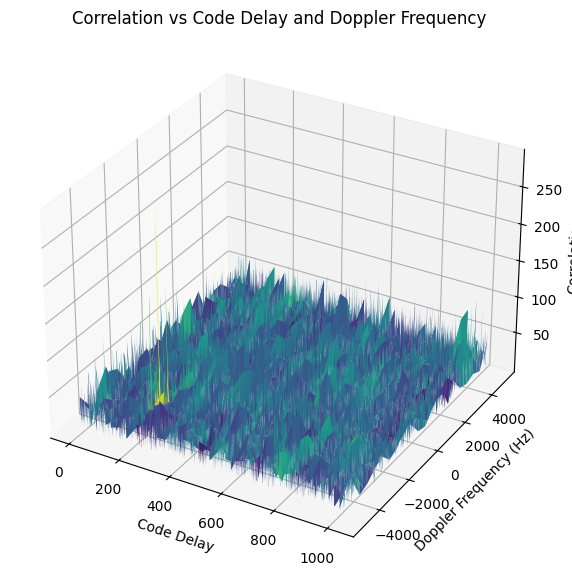

In [545]:
# Plotting
Code_Delay, Doppler_Freq = np.meshgrid(code_delay_range//OV, doppler_freq_range)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Code_Delay, Doppler_Freq, corr_matrix.T, cmap='viridis')
ax.set_xlabel('Code Delay')
ax.set_ylabel('Doppler Frequency (Hz)')
ax.set_zlabel('Correlation')
ax.set_title('Correlation vs Code Delay and Doppler Frequency')
plt.show()

In [546]:
"""
for idx, value in enumerate(degree_list):
    print(f"Index {idx}: {value}")

plt.figure(figsize=(8, 8))
plt.scatter(np.real(cor_lst[:]), np.imag(cor_lst[:]), s=5)

for i, txt in enumerate(range(97, 0 + ms)):
    plt.annotate(f'{txt}', (np.real(cor_lst[i+97]), np.imag(cor_lst[i+97])), fontsize = 8)
    
for i, txt in enumerate(range(0, 0 + B)):
    plt.annotate(f'{txt}', (np.real(cor_lst[i]), np.imag(cor_lst[i])), fontsize = 8)
        
plt.title("Estimated correlation list")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.grid(True)
plt.show()"""
# 주파수 offset = 0일 때 1~20번은 오른쪽, 21~39번이 왼쪽에 있다면 bit boundary 잘 찾은거.(부호반전)
# 위아래로 돌아간 거는 noise에 의한 영향 + 약간의 주파수 offset과 code delay에 관한 거.

'\nfor idx, value in enumerate(degree_list):\n    print(f"Index {idx}: {value}")\n\nplt.figure(figsize=(8, 8))\nplt.scatter(np.real(cor_lst[:]), np.imag(cor_lst[:]), s=5)\n\nfor i, txt in enumerate(range(97, 0 + ms)):\n    plt.annotate(f\'{txt}\', (np.real(cor_lst[i+97]), np.imag(cor_lst[i+97])), fontsize = 8)\n    \nfor i, txt in enumerate(range(0, 0 + B)):\n    plt.annotate(f\'{txt}\', (np.real(cor_lst[i]), np.imag(cor_lst[i])), fontsize = 8)\n        \nplt.title("Estimated correlation list")\nplt.xlabel("Real Part")\nplt.ylabel("Imaginary Part")\nplt.grid(True)\nplt.show()'

Bit boundary 탐색

In [547]:
def find_outliers(data):
    outliers = []
    threshold = 1.5 # 일반적으로는 1.5를 사용합니다.

    data_sorted = sorted(data)
    q1, q3 = np.percentile(data_sorted, [15, 85])
    iqr = q3 - q1

    lower_bound = q1 - (threshold * iqr)
    upper_bound = q3 + (threshold * iqr)

    for i, x in enumerate(data):
        if x < lower_bound or x > upper_bound:
            outliers.append(x)

    return outliers

outliers = find_outliers(degree_list)
print("이상치:", outliers)

outlier_index = 0
if len(outliers)>=1:
    tmp = outliers[0]
    print("첫번째 이상치", tmp)
    idx = degree_list.index(tmp)

    outlier_index = idx + 1
    print("원래", outlier_index)

    if outlier_index>=20:
        outlier_index = outlier_index % 20
        
    print("estimated B", outlier_index)
    print("B", B)
elif len(outliers) == 0:
    print("B = 0")
    
# 이하 다른 알고리즘
"""
def find_outliers_z_score(data, threshold=3):
    mean = np.mean(data)
    std = np.std(data)
    outliers = [(i + 20, x) for i, x in enumerate(data) if abs((x - mean) / std) > threshold]
    return outliers

dl = degree_list[20:40]
outliers_z = find_outliers_z_score(dl)
print("참고: 이상치 (Z-Score):", outliers_z)"""

이상치: [-168.17902974596464, -165.4975395915051, -169.59490771100036, -175.90464985895562, 175.52566412241774, -178.25686345868166]
첫번째 이상치 -168.17902974596464
원래 56
estimated B 16
B 16


'\ndef find_outliers_z_score(data, threshold=3):\n    mean = np.mean(data)\n    std = np.std(data)\n    outliers = [(i + 20, x) for i, x in enumerate(data) if abs((x - mean) / std) > threshold]\n    return outliers\n\ndl = degree_list[20:40]\noutliers_z = find_outliers_z_score(dl)\nprint("참고: 이상치 (Z-Score):", outliers_z)'

In [548]:
# 신호 재정의 : Bit boundary 만큼 뒤로 이동
received_signal.shift(1023*OV * outlier_index)

# 이하 Test
"""sig = received_signal.signal()

signal_div = []

signal_div = [sig[i:i+(1023*OV)] for i in range(0,len(sig), 1023*OV)]
cor_lst = []
stack = 1 # 초기에 시작할 Φ_0
for i in range(ms):
    True_replica = Replica(0, estimated_doppler_freq, code_freq, svNumber, 1023 * OV, OV, stack)
   
    cor = correlate(signal_div[i], True_replica.signal(), mode = 'valid')
    cor_lst.append(np.max(cor))
    stack = True_replica.last# Φ를 저장한 후 다음 반복문에서 사용
    
phase_diff = []
for i in range(1, ms):
        R = cor_lst[i-1] * np.conjugate(cor_lst[i])
        phase_diff.append(np.arctan2(np.imag(R), np.real(R))) 
degree_list = [np.degrees(value) for value in phase_diff]
for i, s in enumerate(degree_list):
    print(f'{i}: {s}')"""

"sig = received_signal.signal()\n\nsignal_div = []\n\nsignal_div = [sig[i:i+(1023*OV)] for i in range(0,len(sig), 1023*OV)]\ncor_lst = []\nstack = 1 # 초기에 시작할 Φ_0\nfor i in range(ms):\n    True_replica = Replica(0, estimated_doppler_freq, code_freq, svNumber, 1023 * OV, OV, stack)\n   \n    cor = correlate(signal_div[i], True_replica.signal(), mode = 'valid')\n    cor_lst.append(np.max(cor))\n    stack = True_replica.last# Φ를 저장한 후 다음 반복문에서 사용\n    \nphase_diff = []\nfor i in range(1, ms):\n        R = cor_lst[i-1] * np.conjugate(cor_lst[i])\n        phase_diff.append(np.arctan2(np.imag(R), np.real(R))) \ndegree_list = [np.degrees(value) for value in phase_diff]\nfor i, s in enumerate(degree_list):\n    print(f'{i}: {s}')"

## Loop

In [549]:
# 20ms 마다 수행하는걸로
current_code_delay = 1023 * OV * outlier_index + estimated_code_delay
current_doppler_freq = estimated_doppler_freq
est_error_freq = 0
current_phase_offset = 0

cumulative_phase = 0

# Plot 할 것들(초기값으로 채워주기)
dop_freq_lst = [current_doppler_freq]
phase_offset_lst = [0]
code_delay_lst = [current_code_delay] 

# 복조 결과
result = []
stack_P = 1# 초기에 시작할 Φ_0
stack_L = 1
stack_E = 1

cor_result = []

for L in range(ms//20):
    sig = received_signal.signal()
    signal_div = []
    signal_div = [sig[i:i+(1023*OV)] for i in range(0,len(sig), 1023*OV)]
    
    cor_lst_P = []
    cor_lst_L = []
    cor_lst_E = []
    
     
    for i in range(20):
        replica_P = Replica(0, current_doppler_freq, code_freq, svNumber, 1023 * OV, OV, stack_P)
        replica_L = Replica(OV//2, current_doppler_freq, code_freq, svNumber, 1023 * OV, OV, stack_L)
        replica_E = Replica(-OV//2, current_doppler_freq, code_freq, svNumber, 1023 * OV, OV, stack_E)
        
        cor_P = correlate(signal_div[20 * L + i], replica_P.signal(), mode = 'valid')
        cor_lst_P.append(np.max(cor_P) * np.exp(1j * current_phase_offset))     # PLL에서 구한 위상 오차 보상
        stack_P = replica_P.last # Φ를 저장한 후 다음 반복문에서 사용
        
        cor_L = correlate(signal_div[20 * L + i], replica_L.signal(), mode = 'valid')
        cor_lst_L.append(np.abs(np.max(cor_L) * np.exp(1j * current_phase_offset)))           # 얘네 두 개는 크기만 비교하는 거라 절댓값 취해줌
        stack_L = replica_L.last 
        
        cor_E = correlate(signal_div[20 * L + i], replica_E.signal(), mode = 'valid')
        cor_lst_E.append(np.abs(np.max(cor_E) * np.exp(1j * current_phase_offset)))     
        stack_E = replica_E.last 
    
    # 교재에서는 I,Q 나눠서 하던데 여기서는 무시함
        
        
    if L != 0:
        phase_diff = [temp]
    else:
        phase_diff = []
    for i in range(1, 20):
        R = cor_lst_P[i-1] * np.conjugate(cor_lst_P[i])
        phase_diff.append(np.arctan2(np.imag(R), np.real(R))) 
    temp = phase_diff[-1]
    
    degree_list = [np.degrees(value) for value in phase_diff]
    
    # FLL
    # 의도적 성능 저하(Loop 시에 그래프 jitter 보려고) 초반 2개의 차이만 보고 평균 구하기
    phase_diff_mean = np.average(phase_diff[:2])
    degree_mean = np.degrees(phase_diff_mean)
    
    #주파수 update
    est_error_freq = 1000 * degree_mean / 360
    current_doppler_freq -= est_error_freq
    dop_freq_lst.append(current_doppler_freq)

    # 20개 한 곳으로 몰아주기(1자로)
    new = [0] * 20
    if L == 0:
        new[0] = cor_lst_P[0]
        for j in range(len(cor_lst_P[1:20])):
            cumulative_phase += phase_diff[j]
            new[j+1] = cor_lst_P[j+1] * np.exp(1j * cumulative_phase)
    elif L != 0:
        #if abs(degree_list[0] - degree_list[1]) > 45:                       # 이거 인식못함 그런데 결과에 문제는 없는듯
                #print('bit change')
                # cumulative_phase += np.pi
        for j in range(20):
            cumulative_phase += phase_diff[j]
            new[j] = cor_lst_P[j] * np.exp(1j * cumulative_phase)
    
    # PLL
    # 처음에 90도 이상 돌아간채로 시작하면 부호 뒤집힌 결과 출력하고 있음.
    # 어떻게 해야 할까?
    
    angles = np.angle(new) # In Radian
    mean_angles = np.average(angles)
    if np.abs(mean_angles) > (np.pi) / 2:
        if mean_angles > 0:
            phase_offset = np.pi - mean_angles
        else:
            phase_offset = -(np.pi + mean_angles)
    else: # np.pi /2 보다 작을 때(1사분면, 4사분면)
        phase_offset = - mean_angles
    current_phase_offset += phase_offset
    
    phase_offset_lst.append(np.degrees(current_phase_offset))
    
    cor_result.append(new)
    
    # DLL 
    avg_E = cor_lst_E[0]
    avg_L = cor_lst_L[0]
    print(avg_E, avg_L)
    e = avg_E - avg_L
    print(avg_E * 0.1)
    if abs(e) < avg_E * 0.1:
        current_code_delay = current_code_delay
        print('stay')
    else:    
        if e < 0:
            current_code_delay += 1
            received_signal.shift(1)
            print('late')
        elif e > 0:
            current_code_delay -= 1
            received_signal.shift(-1)
            print('early')
    code_delay_lst.append(current_code_delay)
    

    # Demodulation
    Decision_variable = np.average(new)
    # cor_result.append(Decision_variable)
    if np.real(Decision_variable) > 0:
        result.append(1)
    else:
        result.append(-1)
    


243.45843205644272 136.3440769114822
24.34584320564427
early
211.51535827482235 153.2938332163943
21.151535827482235
early
174.05157611855688 184.83284532918805
17.40515761185569
stay
208.56550121125514 144.9346875506907
20.856550121125515
early
166.21379428801407 228.68828142224496
16.621379428801408
late
174.6816456077986 198.5648317969141
17.46816456077986
late
226.45180867941036 126.88225850703343
22.645180867941036
early
194.56153410478558 199.65427413188806
19.45615341047856
stay
172.87814242984675 212.4827878161882
17.287814242984677
late
212.2542451069318 120.35099399357604
21.22542451069318
early
167.79684183687985 160.2463465490278
16.779684183687987
stay
153.9991704415097 172.42010278052246
15.399917044150971
late
225.4501833934611 147.76656758088356
22.54501833934611
early
217.48798220412618 143.53338711481368
21.74879822041262
early
159.15795427848207 233.78863803763292
15.915795427848208
late


## 결과 출력

Current Noise Power: 79.1151879879426
Data:
 -1 -1  1  1 -1 -1  1 -1 -1  1  1 -1 -1 -1 -1
Demodulation result:
 -1 -1  1  1 -1 -1  1 -1 -1  1  1 -1 -1 -1 -1
True Freq offset: -3525
True Code delay: 16590.8


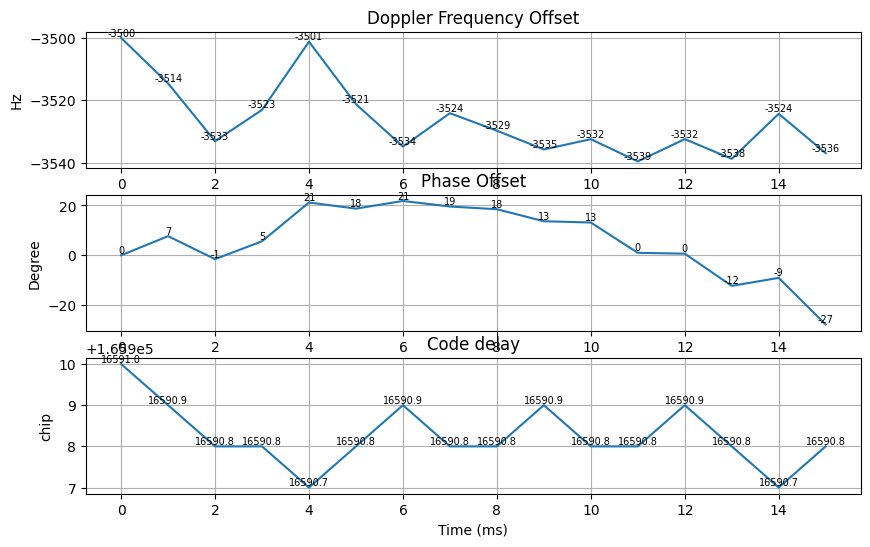

In [550]:
print('Current Noise Power:', noise_power)
print('Data:')
for d in data:
    print("%3d" %d, end = "")
print()
print('Demodulation result:')
for r in result:
    print("%3d" %r, end = "")
print()
print("True Freq offset:", true_doppler_freq)    
print("True Code delay:", true_code_delay / OV)
# 그래프 그리기
plt.figure(figsize=(10, 6))
t = np.arange(0,ms/20 + 1)

plt.subplot(3, 1, 1)
m = np.average(dop_freq_lst[1:])
plt.plot(t, dop_freq_lst)
# plt.ylim(0.8*m, 1.2*m)
for i, v in enumerate(t):
    plt.text(v, dop_freq_lst[i], int(dop_freq_lst[i]),
            fontsize = 7,
            color = 'black',
            horizontalalignment = 'center',
            verticalalignment = 'bottom'
            )
    
plt.title('Doppler Frequency Offset')
plt.xlabel('Time (20ms)')
plt.ylabel('Hz')
plt.grid(True)


plt.subplot(3, 1, 2)
plt.plot(t,phase_offset_lst)
for i, v in enumerate(t):
    plt.text(v, phase_offset_lst[i], int(phase_offset_lst[i]),
            fontsize = 7,
            color = 'black',
            horizontalalignment = 'center',
            verticalalignment = 'bottom'
            )
plt.title('Phase Offset')
plt.xlabel('Time (ms)')
plt.ylabel('Degree')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(t,code_delay_lst)
for i, v in enumerate(t):
    plt.text(v, code_delay_lst[i], code_delay_lst[i] / OV,
            fontsize = 7,
            color = 'black',
            horizontalalignment = 'center',
            verticalalignment = 'bottom'
            )
plt.title('Code delay')
plt.xlabel('Time (ms)')
plt.ylabel('chip')
plt.grid(True)



plt.show()

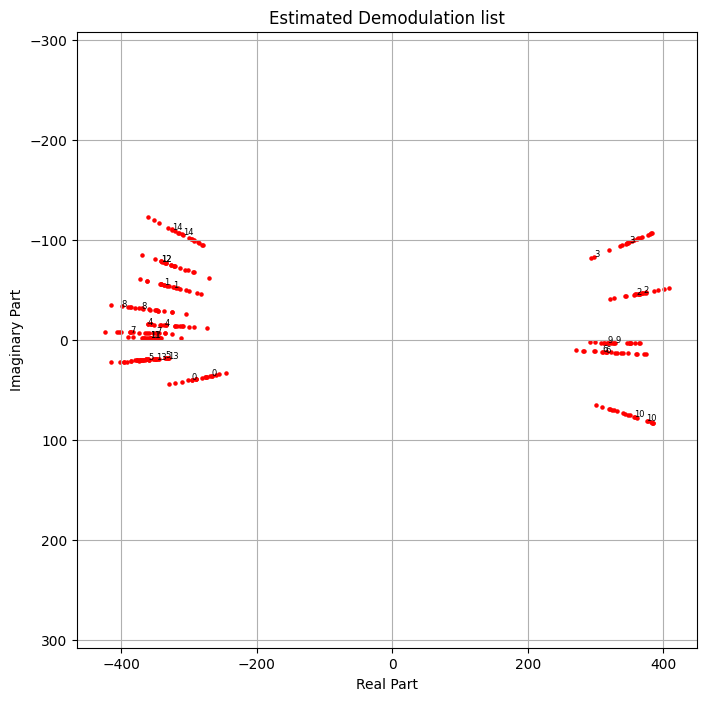

In [551]:

plt.figure(figsize=(8, 8))
for i in range(ms//20):
    plt.scatter(np.real(cor_result[i]), np.imag(cor_result[i]), s=5, label='New_s_1', c='r')    

for i, txt in enumerate(range(ms//20)):
    plt.annotate(f'{txt}', (np.real(cor_result[i][0]), np.imag(cor_result[i][0])), fontsize = 6)
for i, txt in enumerate(range(ms//20)):
    plt.annotate(f'{txt}', (np.real(cor_result[i][-1]), np.imag(cor_result[i][-1])), fontsize = 6)    
    
plt.title("Estimated Demodulation list")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
m = max(np.real(cor_result[-1][:]))
# plt.xlim(-1.1*m, 1.1*m)
plt.ylim(-1.1*m, 1.1*m)
plt.grid(True)
plt.show()

# 첫번째는 버리는 Bit입니다. 이상한 데 있는게 맞는거임